<a href="https://colab.research.google.com/github/FGalvao77/Implementando-DCGAN-do-zero/blob/main/Implementando_DCGAN_do_zero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Implementando `DCGAN` do zero**

---



- **[DCGAN paper](https://arxiv.org/abs/1511.06434)**

- **[CelebA dataset](https://www.kaggle.com/dataset/504743cb487a5aed565ce14238c6343b7d650ffd28c071f03f2fd9b25819e6c9)**

In [167]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

# from model import Discriminator, Generator, initialize_weights

In [168]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_disc):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            # entrada: N x channels_img x 64 x 64
            nn.Conv2d(
                channels_img, features_disc,
                kernel_size=4, stride=2, padding=1
            ),  # 32x32
            nn.LeakyReLU(0.2),

            self._block(features_disc, features_disc * 2, 4, 2, 1),     # 16x16
            self._block(features_disc * 2, features_disc * 4, 4, 2, 1), # 8x8
            self._block(features_disc * 4, features_disc * 8, 4, 2, 1), # 4x4

            nn.Conv2d(features_disc * 8, 1, kernel_size=4, stride=2, padding=0),    # 1x1
            nn.Sigmoid()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels, 
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        return self.discriminator(x)

In [169]:
class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_gen):
        super(Generator, self).__init__()
        self.generator = nn.Sequential(
            self._block(z_dim, features_gen * 16, 4, 1, 0),             # X x f_g * 16 x 4 x 4
            self._block(features_gen * 16, features_gen * 8, 4, 2, 1),  # 8x8
            self._block(features_gen * 8, features_gen * 4, 4, 2, 1),   # 16x16
            self._block(features_gen * 4, features_gen * 2, 4, 2, 1),   # 32x32

            nn.ConvTranspose2d(
                features_gen * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            nn.Tanh()   # [-1, 1]
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False
            ), 
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.generator(x)

In [170]:
def initialize_weights(model):
    for m in model.modules():
        # if isinstance(m, nn.Conv2d):
        #     nn.init.normal(m.weight.data, 0.0, 0.02)

        # if isinstance(m, nn.ConvTranspose2d):
        #     nn.init.normal(m.weight.data, 0.0, 0.02)

        # if isinstance(m, nn.BatchNorm2d):
        #     nn.init.normal(m.weight.data, 0.0, 0.02)

        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [171]:
def test():
    N, in_channels, H, W = 8, 3, 64, 64
    z_dim = 100

    x = torch.randn((N, in_channels, H, W))
    discriminator = Discriminator(in_channels, 8)
    initialize_weights(discriminator)
    assert discriminator(x).shape == (N, 1, 1, 1)

    y = torch.randn((N, z_dim, 1, 1))
    generator = Generator(z_dim, in_channels, 8)
    initialize_weights(generator)
    assert generator(y).shape == (N, in_channels, H, W)

    print('Success')

In [172]:
test()

Success


In [173]:
# hiperparâmetros
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

LEARNING_RATE = 2e-4
BATCH_SIZE = 128
IMAGE_SIZE = 64
# CHANNELS_IMG = 1  # MNIST dataset
CHANNELS_IMG = 3    # celeb_dataset
Z_DIM = 100
NUM_EPOCHS= 5
NOISE_DIM = 100
FEATURES_DISC = 64
FEATURES_GEN = 64

In [174]:
transforms = transforms.Compose(
    [
     transforms.Resize(IMAGE_SIZE),
     transforms.ToTensor(),
     transforms.Normalize(
         [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
     )
    ]
)

In [35]:
# função para acessar o google drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
# com a função "unzip" iremos descompactar o arquivo e, salvar todo seu conteúdo na pasta "/content/celeb_dataset"
!unzip /content/drive/MyDrive/celeb_dataset.zip -d '/content/celeb_dataset'

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: /content/celeb_dataset/images/197600.jpg  
  inflating: /content/celeb_dataset/images/197601.jpg  
  inflating: /content/celeb_dataset/images/197602.jpg  
  inflating: /content/celeb_dataset/images/197603.jpg  
  inflating: /content/celeb_dataset/images/197604.jpg  
  inflating: /content/celeb_dataset/images/197605.jpg  
  inflating: /content/celeb_dataset/images/197606.jpg  
  inflating: /content/celeb_dataset/images/197607.jpg  
  inflating: /content/celeb_dataset/images/197608.jpg  
  inflating: /content/celeb_dataset/images/197609.jpg  
  inflating: /content/celeb_dataset/images/197610.jpg  
  inflating: /content/celeb_dataset/images/197611.jpg  
  inflating: /content/celeb_dataset/images/197612.jpg  
  inflating: /content/celeb_dataset/images/197613.jpg  
  inflating: /content/celeb_dataset/images/197614.jpg  
  inflating: /content/celeb_dataset/images/197615.jpg  
  inflating: /content/celeb_dataset/images/19

In [175]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

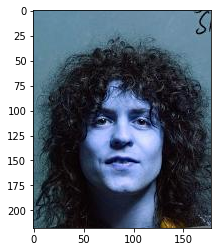

In [176]:
path='/content/celeb_dataset/images/201890.jpg'
img = cv2.imread(path)

plt.imshow(img)
plt.show()

In [177]:
def load_images(directory, n_images):
    images = []
    i = 0

    for file in os.listdir(directory):
        filename = directory + file
        image = cv2.imread(filename)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = np.asarray(image)
        images.append(image)
        i += 1

        if i >= n_images:
            break

    return np.asarray(images)

In [178]:
images = load_images('/content/celeb_dataset/images/', 15)
images

array([[[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        ...,

        [[154,   5,  25],
         [155,   6,  26],
         [156,   7,  27],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[157,   5,  28],
         [154,   5,  27],
         [153,   4,  26],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[157,   5,  28],
         [156,   4,  27],
         [153,   4,  26],
         ...,
         [255, 255, 255],
        

In [179]:
type(images)

numpy.ndarray

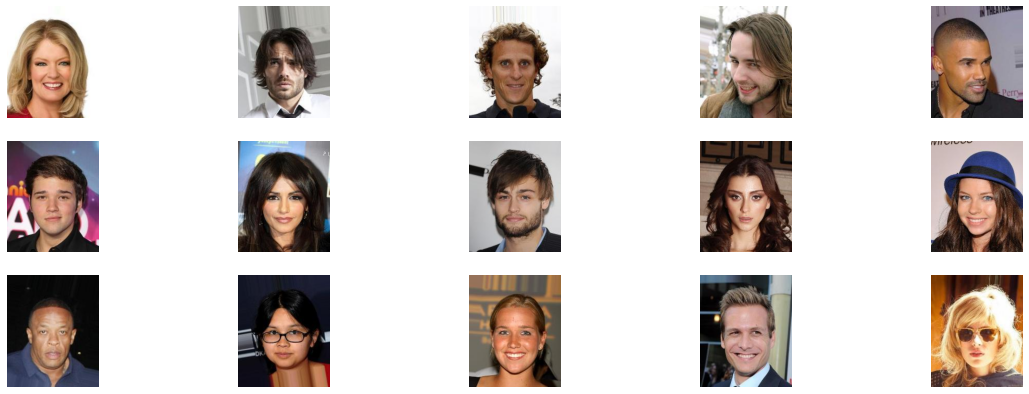

In [180]:
plt.figure(figsize=(20,7))

for i in range(15):
    plt.subplot(3, 5, 1 + i)
    plt.axis('off')
    plt.imshow(images[i])

plt.show();

In [181]:
# MNIST dataset
# dataset = datasets.MNIST(root='dataset/', train=True, 
#                          transform=transforms, download=True)

dataset = datasets.ImageFolder(root='celeb_dataset', transform=transforms)

In [182]:
loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)

In [183]:
generator = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
discriminator = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)

In [184]:
initialize_weights(discriminator)
initialize_weights(generator)

In [185]:
opt_disc = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_gen = optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

In [186]:
criterion = nn.BCELoss()

In [187]:
fixed_noise = torch.rand(32, Z_DIM, 1, 1).to(device)

In [188]:
writer_real = SummaryWriter(f'logs/real')
writer_fake = SummaryWriter(f'logs/fake')

In [189]:
# step = 0

In [190]:
generator.train()

Generator(
  (generator): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): ConvTranspose2d(12

In [191]:
discriminator.train()

Discriminator(
  (discriminator): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
    (6): Sigmoid()
  )
)

In [ ]:
step = 0

for epoch in range(NUM_EPOCHS):
    # Target labels not needed! <3 unsupervised
    for batch_idx, (real, _) in enumerate(loader):
        real = real.to(device)
        noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
        fake = generator(noise)

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        disc_real = discriminator(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))

        disc_fake = discriminator(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))

        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        discriminator.zero_grad()
        loss_disc.backward(retain_graph=True)
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        output = discriminator(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        generator.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Print losses occasionally and print to tensorboard
        if batch_idx % 100 == 0:
            print(
                f'Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(loader)} \
                  Loss D: {loss_disc:.4f}, Loss G: {loss_gen:.4f}'
            )

            with torch.no_grad():
                fake = generator(fixed_noise)
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(
                    real[:32], normalize=True
                )
                img_grid_fake = torchvision.utils.make_grid(
                    fake[:32], normalize=True
                )

                writer_real.add_image('Real', img_grid_real, global_step=step)
                writer_fake.add_image('Fake', img_grid_fake, global_step=step)

            step += 1

Epoch [0/5] Batch 0/1583                   Loss D: 0.6983, Loss G: 0.7869
Epoch [0/5] Batch 100/1583                   Loss D: 0.0299, Loss G: 3.8059
Epoch [0/5] Batch 200/1583                   Loss D: 0.0054, Loss G: 5.2471
Epoch [0/5] Batch 300/1583                   Loss D: 0.0026, Loss G: 5.8337
Epoch [0/5] Batch 400/1583                   Loss D: 0.0014, Loss G: 6.3140
Epoch [0/5] Batch 500/1583                   Loss D: 0.0009, Loss G: 6.7604
Epoch [0/5] Batch 600/1583                   Loss D: 0.0005, Loss G: 7.2790
Epoch [0/5] Batch 700/1583                   Loss D: 0.0004, Loss G: 7.5510
Epoch [0/5] Batch 800/1583                   Loss D: 0.0003, Loss G: 7.8266
Epoch [0/5] Batch 900/1583                   Loss D: 0.0003, Loss G: 8.1457
Epoch [0/5] Batch 1000/1583                   Loss D: 0.0002, Loss G: 8.3722
Epoch [0/5] Batch 1100/1583                   Loss D: 0.0002, Loss G: 8.6019
Epoch [0/5] Batch 1200/1583                   Loss D: 0.0001, Loss G: 8.8420
Epoch [0/5]